In [230]:
import numpy as np
import pandas as pd
import os
import cv2 as cv

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split as split

In [231]:
#Based on: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
#This cell sets all seeds, such that each iteration with the same settings will yield the same results
#To test this, one needs to re-run the whole notebook instead of just one cell

# Seed value
# Apparently you may use different seed values at each stage
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


In [232]:
# The paths used to store the images

# As one can see, if one wants to test this themselves,
# please set the main path to the path that leads to
# the "chest_xray" folder of the dataset

main_path = r"U:\Year 2\NN\modelData\archive\chest_xray"
test_path = os.path.join(main_path, "test")
train_path = os.path.join(main_path, "train")

In [233]:
def get_paths_and_labels(directory):
    """
    Creates dataset with path of each individual image in directory with their label
    """
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpeg"):
            label = "Normal"
            if "PNEUMONIA" in directory:
                if "bacteria" in filename.lower():
                    label = "Pneumonia - Bacteria"
                elif "virus" in filename.lower():
                    label = "Pneumonia - Virus"
            data.append([os.path.join(directory, filename), label])
    return data

def get_set(directory):
    """
    Returns pandas dataframe of paths to images and their labels
    """
    pneumonia = os.path.join(directory, "PNEUMONIA")
    normal = os.path.join(directory, "NORMAL")

    dataset = get_paths_and_labels(pneumonia)
    dataset = pd.DataFrame(dataset, columns=list(["path", "label"]))
    
    dataset2 = get_paths_and_labels(normal)
    dataset2 = pd.DataFrame(dataset2, columns=list(["path", "label"]))
    
    dataset = dataset.append(dataset2, ignore_index=True)
    return dataset

In [234]:
# Define the image sets
test = get_set(test_path)
train = get_set(train_path)

# Split the validation set from the train set
train_x, val_x, train_y, val_y = split(train["path"], train["label"], shuffle=True, test_size = 0.2, train_size = 0.8)

train = pd.concat([train_x, train_y.astype(str)], axis=1)
val = pd.concat([val_x, val_y.astype(str)], axis=1)

In [235]:
import matplotlib.pyplot as plt
import matplotlib.patches as patch

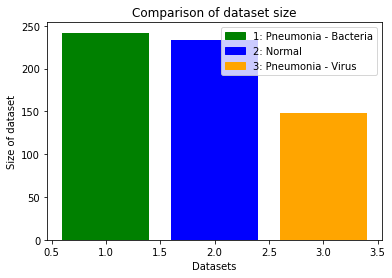

In [236]:
# This cell creates a plot to see the size of each dataset

fig, ax = plt.subplots()

leg_list = []

colour = {
    0:'green',
    1:'blue',
    2:'orange'    
}

data = test['label'].value_counts()
values = data.keys()
total = sum(data)

for i in range(len(values)):
    temp_patch = patch.Patch(color=colour[i], label="%i: %s" %(i + 1, values[i]))
    leg_list.append(temp_patch)
    plt.bar(i + 1, data[i], color=colour[i])

plt.ylabel("Size of dataset")
plt.xlabel("Datasets")
plt.title("Comparison of dataset size")

plt.legend(handles=leg_list)
plt.savefig(os.path.join(main_path, "sizeCompBefore.jpeg"))
plt.show()

In [237]:
# The code in this cell is never used, therefore one can ignore it
# However, it may not be removed, as the random number generators would
# otherwise behave differently

import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

size = 3

def generate_norm_pics(amount, path):
    gs = gridspec.GridSpec(2, amount)

    pl.figure()
    for j in range(0, 2):
        if j:
            mod_path = os.path.join(path, "NORMAL")
        else:
            mod_path = os.path.join(path, "PNEUMONIA")

        for i in range(amount):
            ax = pl.subplot(gs[j, i])

            #Taken from: https://stackoverflow.com/questions/26467804/how-to-display-a-random-picture-from-a-folder
            img_path = random.choice([
                x for x in os.listdir(mod_path)
                if os.path.isfile(os.path.join(mod_path, x))
            ])

            print(img_path)
            pl.imread(img_path, format=float)
            ax.imshow(img_path)
            pl.plot([0,1])

#generate_norm_pics(size, test_path)

In [238]:
# Defining the shape of the input and the batch size

SHAPE = (256, 256)
BATCH_SIZE = 32

In [239]:
# Initiate ImageDataGenerators
train_gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.5,
    brightness_range=[0.75, 1.25],
)

val_gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.5,
    brightness_range=[0.75, 1.25],
)

test_gen = ImageDataGenerator(
    rescale=1/255.,
)

train_generator = train_gen.flow_from_dataframe(
        train,
        x_col="path",
        y_col="label",
        color_mode ="grayscale",
        target_size=SHAPE,
        batch_size=BATCH_SIZE
        )

val_generator = val_gen.flow_from_dataframe(
        val,
        x_col="path",
        y_col="label",
        color_mode ="grayscale",
        target_size=SHAPE,
        batch_size=BATCH_SIZE
        )

test_generator = test_gen.flow_from_dataframe(
        test,
        x_col="path",
        y_col="label",
        color_mode ="grayscale",
        target_size=SHAPE,
        batch_size=BATCH_SIZE
        )

Found 4185 validated image filenames belonging to 3 classes.
Found 1047 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


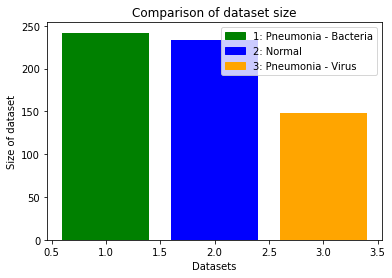

In [240]:
# To confirm the data generators did not mess anything up

fig, ax = plt.subplots()

leg_list = []

colour = {
    0:'green',
    1:'blue',
    2:'orange'    
}

data = test['label'].value_counts()
values = data.keys()
total = sum(data)

for i in range(len(values)):
    temp_patch = patch.Patch(color=colour[i], label="%i: %s" %(i + 1, values[i]))
    leg_list.append(temp_patch)
    plt.bar(i + 1, data[i], color=colour[i])

plt.ylabel("Size of dataset")
plt.xlabel("Datasets")
plt.title("Comparison of dataset size")

plt.legend(handles=leg_list)
plt.savefig(os.path.join(main_path, "sizeCompAfter.jpeg"))
plt.show()

In [241]:
# Calculating the weights for each class

_, freq = np.unique(train["label"], return_counts=True)
norm = freq[0]
bact = freq[1]
vir = freq[2]

total = norm + bact + vir
weight_norm = (1 / norm) * (total / 3.0)
weight_bact = (1 / bact) * (total / 3.0)
weight_vir = (1 / vir) * (total / 3.0)

class_weight = {0: weight_norm, 1: weight_bact, 2: weight_vir}

print('Weight for class 0: {:.2f}'.format(weight_norm))
print('Weight for class 1: {:.2f}'.format(weight_bact))
print('Weight for class 2: {:.2f}'.format(weight_vir))

Weight for class 0: 1.28
Weight for class 1: 0.69
Weight for class 2: 1.31


In [242]:
# Defining the architecture of the model

act = "relu"

model = keras.Sequential()
for i in range(0, 4):
    model.add(layers.Conv2D(10, 5, padding="same", activation=act, input_shape = (SHAPE[0], SHAPE[1], 1)))
    model.add(layers.MaxPool2D())
    model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation=act))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(3, activation="softmax"))

In [243]:
# Compiling the model

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
    )

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 256, 256, 10)      260       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 128, 128, 10)      0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 128, 128, 10)      40        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 128, 128, 10)      2510      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 64, 64, 10)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 64, 64, 10)        40        
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 64, 64, 10)      

In [244]:
# Getting an initial impression of the model before training
model.evaluate(
    test_generator,
    batch_size=BATCH_SIZE,
    verbose=1
    )

20/20 [==============================] - 3s 106ms/step - loss: 1.0965 - accuracy: 0.3878


[1.0964592695236206, 0.3878205120563507]

In [246]:
# Defining the amount of epochs and training parameters
epochs = 100

amazing_model = model.fit(
    train_generator,
    epochs = epochs,
    batch_size=BATCH_SIZE,
    verbose = 2,
    validation_data=val_generator,
    shuffle=True,
    class_weight=class_weight
    )

Epoch 1/100
131/131 [==============================] - 47s 350ms/step - loss: 0.9865 - accuracy: 0.5692 - val_loss: 1.7479 - val_accuracy: 0.3983
Epoch 2/100
131/131 [==============================] - 46s 350ms/step - loss: 0.7545 - accuracy: 0.6220 - val_loss: 2.3584 - val_accuracy: 0.3286
Epoch 3/100
131/131 [==============================] - 45s 347ms/step - loss: 0.7267 - accuracy: 0.6485 - val_loss: 1.8004 - val_accuracy: 0.5100
Epoch 4/100
131/131 [==============================] - 45s 344ms/step - loss: 0.6767 - accuracy: 0.6686 - val_loss: 2.2789 - val_accuracy: 0.4537
Epoch 5/100
131/131 [==============================] - 45s 343ms/step - loss: 0.6631 - accuracy: 0.6898 - val_loss: 0.6894 - val_accuracy: 0.6600
Epoch 6/100
131/131 [==============================] - 45s 345ms/step - loss: 0.6398 - accuracy: 0.6992 - val_loss: 1.0806 - val_accuracy: 0.6180
Epoch 7/100
131/131 [==============================] - 45s 344ms/step - loss: 0.6491 - accuracy: 0.7018 - val_loss: 0.6056 -

In [249]:
model.evaluate(test_generator)

20/20 [==============================] - 2s 119ms/step - loss: 0.4430 - accuracy: 0.8718


[0.4429914951324463, 0.8717948794364929]

In [260]:
# Change the folder_name if you want to save an alternative model
# otherwise, just saves the model as is in the path provided
folder_name = "basisModel1"
model.save(os.path.join(main_path, folder_name))

INFO:tensorflow:Assets written to: U:\Year 2\NN\modelData\archive\chest_xray\basisModel1\assets


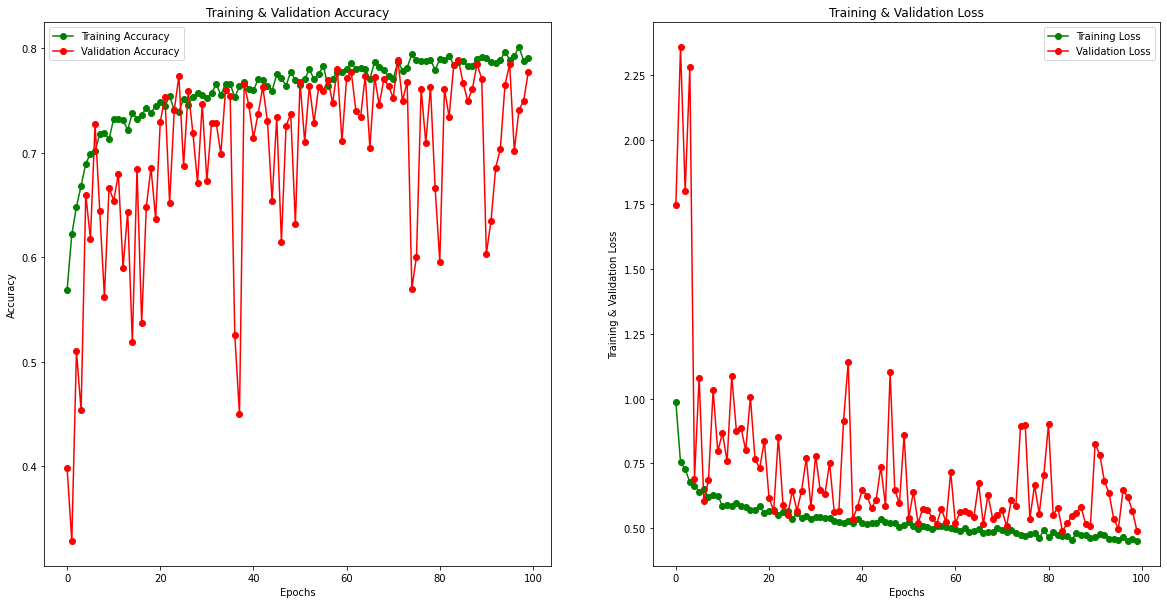

In [261]:
# Based on: https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy#Analysis-after-Model-Training

e = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = amazing_model.history['accuracy']
train_loss = amazing_model.history['loss']
val_acc = amazing_model.history['val_accuracy']
val_loss = amazing_model.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(e , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(e , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(e , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(e , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
img_path = os.path.join(main_path, folder_name)
plt.savefig(os.path.join(img_path, "modelAccLoss.jpeg"))
plt.show()

In [268]:
# Again, the code in this cell is never used
# It is only kept here for historical accuracy

y_pred=(model.predict(test_generator) > 0.5).astype("int32")
y_classes = y_pred.argmax(axis=-1)
con_mat = tf.math.confusion_matrix(labels=test_generator['label'], predictions=y_classes).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

TypeError: '>=' not supported between instances of 'str' and 'int'